In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.stats import gamma, poisson
import matplotlib as mpl
import itertools
import matplotlib.pyplot as plt
import re

In [2]:
df_covid = pd.read_excel('../data/covid_data.xlsx')
df_covid = df_covid.drop(['import'], axis = 1)
df_covid  ## local : 확진자 수


df_covid

,date,local
0,2020-05-01,1
1,2020-05-02,0
2,2020-05-03,3
3,2020-05-04,0
4,2020-05-05,0
...,...,...
559,2021-11-11,2494
560,2021-11-12,2358
561,2021-11-13,2310
562,2021-11-14,2401


In [3]:
import epyestim
import epyestim.covid19 as covid19

In [4]:
# todo 내장함수 불러오기
si_distrb = covid19.generate_standard_si_distribution() ## serial interval mean 4.3일을 고려한 분포 생성
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution() ## 평균 delay mean : 10.3일 고려한 분포 생성

In [8]:
print(delay_distrb.shape)
print(si_distrb.shape)

(166,)
(18,)


In [42]:
# 데이터 불러오기
ch_cases = pd.read_excel(
    os.path.join('', '../data/covid_data.xlsx'),
    parse_dates = ['date'],
).set_index('date')['local']

ch_cases

date
2020-05-01       1
2020-05-02       0
2020-05-03       3
2020-05-04       0
2020-05-05       0
              ... 
2021-11-11    2494
2021-11-12    2358
2021-11-13    2310
2021-11-14    2401
2021-11-15    1986
Name: local, Length: 564, dtype: int64

In [43]:
# 내장함수로 계산
ch_time_varying_r = covid19.r_covid(ch_cases, gt_distribution = si_distrb)
ch_time_varying_r.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-11-01,1664.0,1.050691,0.000154,1.026516,1.050642,1.075141
2021-11-02,1578.0,1.025501,0.000146,1.001864,1.025454,1.049329
2021-11-03,2640.0,1.008284,0.000142,0.985105,1.008237,1.031698
2021-11-04,2457.0,0.998771,0.000140,0.975678,0.998724,1.022067
2021-11-05,2322.0,0.993147,0.000139,0.970185,0.993100,1.016425


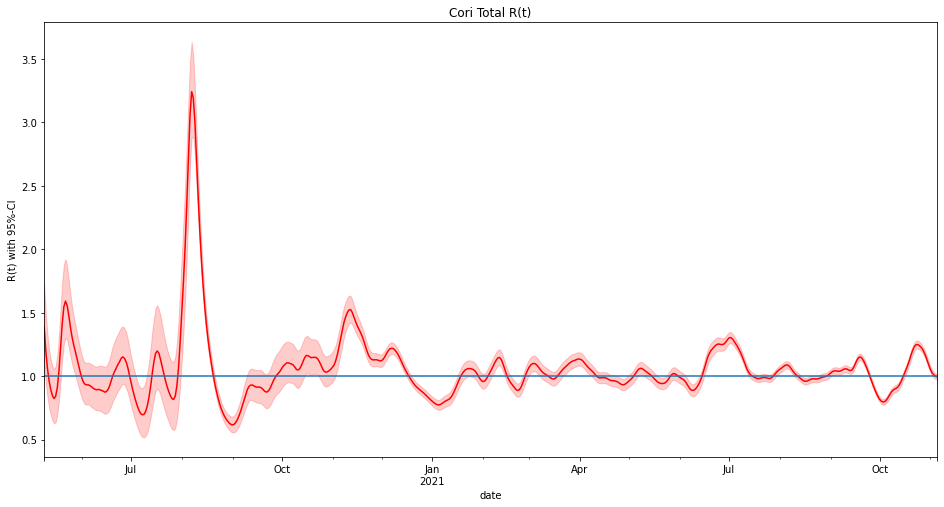

In [34]:
# 그래프
fig, ax = plt.subplots(1,1, figsize=(16, 8))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
# CI
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.axhline(y=1)
ax.set_title('Cori Total R(t)')
plt.show()

## Cori Rt 계산 방법
- 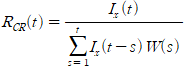

In [44]:
# Cori의 Ws Gamma 분포 함수
def W(num):
    from numpy import linspace, exp
    x = linspace(1, num, num)
    from scipy.special import gamma
    mu = 4.8
    sig = 2.3
    shape = mu ** 2 / sig ** 2
    scale = sig ** 2 / mu
    y = x ** (shape - 1) * exp(-x / scale) / (scale ** shape * gamma(shape)) ## gamma 분포의 pdf 정의
    W = y
    return W

In [45]:
# Cori 계산 함수
def Cori(i, data, W):
    a = data.values[i] ## I_t
    b = 0 ## 초기화
    for k in range(1, i):
        b += data[i-k] * W[k] ## I[t-s] * Ws
    if (b > 0) :
        r = a / b
    else:
        r = 0
    return r

In [48]:
df_covid['W'] = W(len(df_covid))
df_covid

,date,local,W
0,2020-05-01,1,2.770210e-02
1,2020-05-02,0,1.144243e-01
2,2020-05-03,3,1.800138e-01
3,2020-05-04,0,1.907466e-01
4,2020-05-05,0,1.627648e-01
...,...,...,...
559,2021-11-11,2494,2.401001e-213
560,2021-11-12,2358,9.748223e-214
561,2021-11-13,2310,3.957800e-214
562,2021-11-14,2401,1.606859e-214


In [49]:
# Rt 계산
for i in range(1, len(df_covid.index)):
    df_covid.loc[i, 'Cori'] = Cori(i, df_covid['local'], df_covid['W'])
df_covid

,date,local,W,Cori
0,2020-05-01,1,2.770210e-02,NaN
1,2020-05-02,0,1.144243e-01,0.000000
2,2020-05-03,3,1.800138e-01,0.000000
3,2020-05-04,0,1.907466e-01,0.000000
4,2020-05-05,0,1.627648e-01,0.000000
...,...,...,...,...
559,2021-11-11,2494,2.401001e-213,1.243435
560,2021-11-12,2358,9.748223e-214,1.148363
561,2021-11-13,2310,3.957800e-214,1.089071
562,2021-11-14,2401,1.606859e-214,1.102904


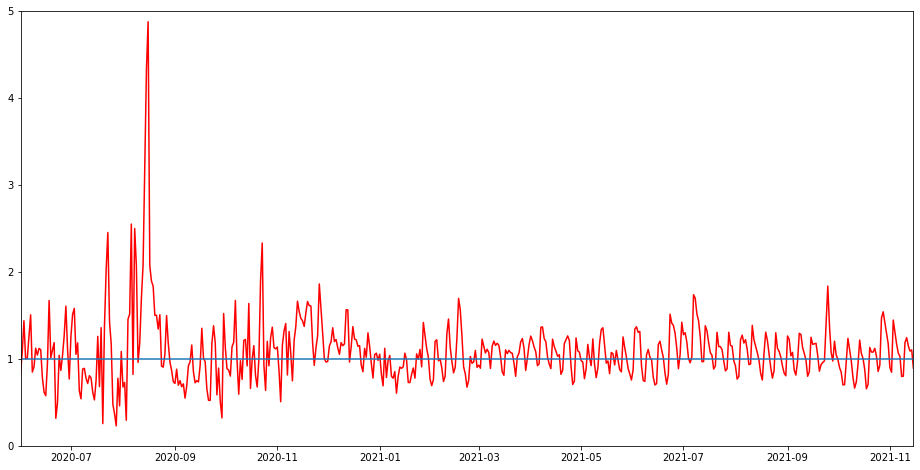

In [51]:
# 계산한 기본 그래프
plt.figure(figsize=(16, 8))
x=df_covid['date']
y=df_covid['Cori']
plt.plot(x,y,'r')
plt.xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
plt.ylim([0,5])
plt.axhline(y=1)
plt.show()

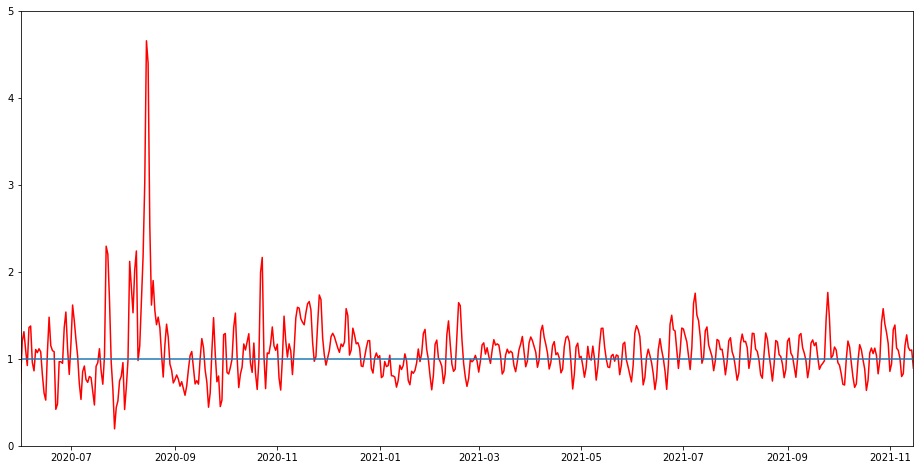

In [52]:
# smoothing filter 쓰운 그래프
plt.figure(figsize=(16, 8))
x=df_covid['date']
y=df_covid['Cori']
yhat=savgol_filter(y,11,9)
plt.plot(x,yhat,'r')
plt.xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
plt.ylim([0,5])
plt.axhline(y=1)
plt.show()